# Modeling Notebook

## Library Imports

In [5]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

In [6]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [7]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## 1. Data Access and Structure

### 1.1 Loading Cleaned Dataset

In [8]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

# get the dataset schema
schema = scan.collect_schema()

In [9]:
# set feature and target variables
TARGET_LABEL = 'Label'
TARGET_FAMILY = 'Label_Family'
TARGET_BINARY = 'Label_Binary'

all_columns = schema.names()
target_columns = [TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]
feature_columns = [col for col in all_columns if col not in target_columns]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col not in target_columns]



## 2. Linear Model Assumptions & Preprocessing Design

### 2.1 Multicollinearity and Redundancy

### 2.2 Scaling Strategy for Numeric Features

### 2.3 Skewness and Transformations

### 2.4 Class Balance Profiling on Target Granularities

## 3. Stratified Equal-Sized Subsampling Strategy

### 3.1 Global Subsampling Parameters

In [10]:
def get_class_counts(lazy_scan: pl.LazyFrame, target_col: str) -> pl.DataFrame:
    """
    Return a Polars DataFrame with class counts for the given target column.
    Uses lazy scan -> group_by -> aggregate -> collect.
    """
    counts = (
        lazy_scan
        .group_by(target_col)
        .agg(pl.len().alias("count"))
        .collect()
        .sort("count")
    )
    return counts

# Get class counts for each target granularity
label_counts = get_class_counts(scan, TARGET_LABEL)
label_family_counts = get_class_counts(scan, TARGET_FAMILY)
label_binary_counts = get_class_counts(scan, TARGET_BINARY)

print("Label (34-class) counts (sorted by smallest class):")
print(label_counts)

print("\nLabel_Family (7/8-class) counts:")
print(label_family_counts)

print("\nLabel_Binary (2-class) counts:")
print(label_binary_counts)

Label (34-class) counts (sorted by smallest class):
shape: (34, 2)
┌───────────────────┬─────────┐
│ Label             ┆ count   │
│ ---               ┆ ---     │
│ str               ┆ u32     │
╞═══════════════════╪═════════╡
│ UPLOADING_ATTACK  ┆ 1196    │
│ RECON-PINGSWEEP   ┆ 2161    │
│ BACKDOOR_MALWARE  ┆ 3075    │
│ XSS               ┆ 3705    │
│ SQLINJECTION      ┆ 5021    │
│ …                 ┆ …       │
│ DDOS-PSHACK_FLOOD ┆ 1641898 │
│ DDOS-SYN_FLOOD    ┆ 1764599 │
│ DOS-UDP_FLOOD     ┆ 1851682 │
│ DDOS-ICMP_FLOOD   ┆ 1907561 │
│ DDOS-UDP_FLOOD    ┆ 1964164 │
└───────────────────┴─────────┘

Label_Family (7/8-class) counts:
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDO

### 3.2 Subsampling for Label (34 Classes)

In [11]:
# collect the full cleaned dataset once
df = scan.collect()

# desired per-class count
N_PER_CLASS_LABEL = 1000

# compute the minimum available class size to ensure feasibility
label_counts = (
    df.group_by(TARGET_LABEL)
      .len()
      .rename({"len": "count"})
      .sort("count")
)

print("Label class counts (ascending):")
print(label_counts)

min_class_size = label_counts["count"].min()

if N_PER_CLASS_LABEL > min_class_size:
    print(f"\nRequested 1000 per class, but smallest class has only {min_class_size}.")
    print(f"Using {min_class_size} per class instead.")
    N_PER_CLASS_LABEL = min_class_size

print(f"\nFinal per-class sample size for Label: {N_PER_CLASS_LABEL}")

# stratified sampling using random per-class indexing
label_subsample = (
    df
    .with_columns(
        pl.col(TARGET_LABEL),
        pl.lit(0).alias("_dummy")  # stable placeholder
    )
    .with_columns(
        pl.col("_dummy").shuffle(seed=RANDOM_SEED).over(TARGET_LABEL).alias("_rand")
    )
    .with_columns(
        pl.col("_rand").rank("ordinal").over(TARGET_LABEL).alias("_rank")
    )
    .filter(pl.col("_rank") <= N_PER_CLASS_LABEL)
    .drop(["_rand", "_rank", "_dummy"])
)

# shuffle final result so classes are mixed
label_subsample = label_subsample.sample(
    fraction=1.0,
    shuffle=True,
    seed=RANDOM_SEED
)

print("\nLabel subsample shape:", label_subsample.shape)

# sanity check: each class should have the same count
label_subsample_counts = (
    label_subsample.group_by(TARGET_LABEL)
                   .len()
                   .rename({"len": "count"})
                   .sort(TARGET_LABEL)
)

label_subsample_counts

Label class counts (ascending):
shape: (34, 2)
┌───────────────────┬─────────┐
│ Label             ┆ count   │
│ ---               ┆ ---     │
│ str               ┆ u32     │
╞═══════════════════╪═════════╡
│ UPLOADING_ATTACK  ┆ 1196    │
│ RECON-PINGSWEEP   ┆ 2161    │
│ BACKDOOR_MALWARE  ┆ 3075    │
│ XSS               ┆ 3705    │
│ SQLINJECTION      ┆ 5021    │
│ …                 ┆ …       │
│ DDOS-PSHACK_FLOOD ┆ 1641898 │
│ DDOS-SYN_FLOOD    ┆ 1764599 │
│ DOS-UDP_FLOOD     ┆ 1851682 │
│ DDOS-ICMP_FLOOD   ┆ 1907561 │
│ DDOS-UDP_FLOOD    ┆ 1964164 │
└───────────────────┴─────────┘

Final per-class sample size for Label: 1000

Label subsample shape: (34000, 42)


Label,count
str,u32
"""BACKDOOR_MALWARE""",1000
"""BENIGN""",1000
"""BROWSERHIJACKING""",1000
"""COMMANDINJECTION""",1000
"""DDOS-ACK_FRAGMENTATION""",1000
…,…
"""RECON-PORTSCAN""",1000
"""SQLINJECTION""",1000
"""UPLOADING_ATTACK""",1000


### 3.3 Subsampling for Label_Family (8 Classes)

In [12]:
# Desired per-class count
N_PER_CLASS_FAMILY = 10_000

# 1. Compute minimum available class size for safety
family_counts = (
    df.group_by(TARGET_FAMILY)
      .len()
      .rename({"len": "count"})
      .sort("count")
)

print("Label_Family class counts (ascending):")
print(family_counts)

min_family_class = family_counts["count"].min()

if N_PER_CLASS_FAMILY > min_family_class:
    print(f"\nRequested {N_PER_CLASS_FAMILY} per class, "
          f"but smallest family class has only {min_family_class}.")
    print(f"Using {min_family_class} per class instead.")
    N_PER_CLASS_FAMILY = min_family_class

print(f"\nFinal per-class sample size for Label_Family: {N_PER_CLASS_FAMILY}")

# 2. Memory-safe stratified sampling
family_subsample = (
    df
    .with_columns(
        pl.col(TARGET_FAMILY),
        pl.lit(0).alias("_dummy")
    )
    .with_columns(
        pl.col("_dummy").shuffle(seed=RANDOM_SEED).over(TARGET_FAMILY).alias("_rand")
    )
    .with_columns(
        pl.col("_rand").rank("ordinal").over(TARGET_FAMILY).alias("_rank")
    )
    .filter(pl.col("_rank") <= N_PER_CLASS_FAMILY)
    .drop(["_rand", "_rank", "_dummy"])
)

# 3. Shuffle final result so classes are mixed
family_subsample = family_subsample.sample(
    fraction=1.0,
    shuffle=True,
    seed=RANDOM_SEED
)

print("\nLabel_Family subsample shape:", family_subsample.shape)

# 4. Sanity check: each family class should have equal counts
family_subsample_counts = (
    family_subsample.group_by(TARGET_FAMILY)
                    .len()
                    .rename({"len": "count"})
                    .sort(TARGET_FAMILY)
)

family_subsample_counts

Label_Family class counts (ascending):
shape: (8, 2)
┌──────────────┬──────────┐
│ Label_Family ┆ count    │
│ ---          ┆ ---      │
│ str          ┆ u32      │
╞══════════════╪══════════╡
│ BRUTE_FORCE  ┆ 12520    │
│ WEB          ┆ 23707    │
│ SPOOFING     ┆ 436061   │
│ RECON        ┆ 655464   │
│ BENIGN       ┆ 1047308  │
│ MIRAI        ┆ 2359183  │
│ DOS          ┆ 4178919  │
│ DDOS         ┆ 12292078 │
└──────────────┴──────────┘

Final per-class sample size for Label_Family: 10000

Label_Family subsample shape: (80000, 42)


Label_Family,count
str,u32
"""BENIGN""",10000
"""BRUTE_FORCE""",10000
"""DDOS""",10000
"""DOS""",10000
"""MIRAI""",10000
"""RECON""",10000
"""SPOOFING""",10000
"""WEB""",10000


### 3.4 Subsampling for Label_binary (2 Classes)

In [13]:
# Desired per-class count
N_PER_CLASS_BINARY = 100_000

# 1. Compute minimum available class size for safety
binary_counts = (
    df.group_by(TARGET_BINARY)
      .len()
      .rename({"len": "count"})
      .sort("count")
)

print("Label_Binary class counts (ascending):")
print(binary_counts)

min_binary_class = binary_counts["count"].min()

if N_PER_CLASS_BINARY > min_binary_class:
    print(f"\nRequested {N_PER_CLASS_BINARY} per class, "
          f"but smallest binary class has only {min_binary_class}.")
    print(f"Using {min_binary_class} per class instead.")
    N_PER_CLASS_BINARY = min_binary_class

print(f"\nFinal per-class sample size for Label_Binary: {N_PER_CLASS_BINARY}")

# 2. Memory-safe stratified sampling
binary_subsample = (
    df
    .with_columns(
        pl.col(TARGET_BINARY),
        pl.lit(0).alias("_dummy")
    )
    .with_columns(
        pl.col("_dummy").shuffle(seed=RANDOM_SEED).over(TARGET_BINARY).alias("_rand")
    )
    .with_columns(
        pl.col("_rand").rank("ordinal").over(TARGET_BINARY).alias("_rank")
    )
    .filter(pl.col("_rank") <= N_PER_CLASS_BINARY)
    .drop(["_rand", "_rank", "_dummy"])
)

# 3. Shuffle final result so classes are mixed
binary_subsample = binary_subsample.sample(
    fraction=1.0,
    shuffle=True,
    seed=RANDOM_SEED
)

print("\nLabel_Binary subsample shape:", binary_subsample.shape)

# 4. Sanity check: each binary class should have equal counts
binary_subsample_counts = (
    binary_subsample.group_by(TARGET_BINARY)
                    .len()
                    .rename({"len": "count"})
                    .sort(TARGET_BINARY)
)

binary_subsample_counts

Label_Binary class counts (ascending):
shape: (2, 2)
┌──────────────┬──────────┐
│ Label_Binary ┆ count    │
│ ---          ┆ ---      │
│ i32          ┆ u32      │
╞══════════════╪══════════╡
│ 0            ┆ 1047308  │
│ 1            ┆ 19957932 │
└──────────────┴──────────┘

Final per-class sample size for Label_Binary: 100000

Label_Binary subsample shape: (200000, 42)


Label_Binary,count
i32,u32
0,100000
1,100000


## 4. Train/Test Split & Preprocessing Pipelines

### 4.3 Train/Test Split & Pipeline for 'Label' (34 Classes)

In [14]:
# Drop targets from feature matrix
X_label = label_subsample.drop([TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]).to_pandas()

# Extract y for label (string labels are fine for modeling)
y_label = label_subsample[TARGET_LABEL].to_pandas()

# Perform stratified split
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label,
    y_label,
    test_size=0.2,         # 80/20 split
    stratify=y_label,
    random_state=RANDOM_SEED
)

print("Label train:", X_train_label.shape, "Label test:", X_test_label.shape)
print("Label y-train class distribution:\n", y_train_label.value_counts().sort_index())
print("Label y-test class distribution:\n", y_test_label.value_counts().sort_index())

Label train: (27200, 39) Label test: (6800, 39)
Label y-train class distribution:
 Label
BACKDOOR_MALWARE           800
BENIGN                     800
BROWSERHIJACKING           800
COMMANDINJECTION           800
DDOS-ACK_FRAGMENTATION     800
DDOS-HTTP_FLOOD            800
DDOS-ICMP_FLOOD            800
DDOS-ICMP_FRAGMENTATION    800
DDOS-PSHACK_FLOOD          800
DDOS-RSTFINFLOOD           800
DDOS-SLOWLORIS             800
DDOS-SYNONYMOUSIP_FLOOD    800
DDOS-SYN_FLOOD             800
DDOS-TCP_FLOOD             800
DDOS-UDP_FLOOD             800
DDOS-UDP_FRAGMENTATION     800
DICTIONARYBRUTEFORCE       800
DNS_SPOOFING               800
DOS-HTTP_FLOOD             800
DOS-SYN_FLOOD              800
DOS-TCP_FLOOD              800
DOS-UDP_FLOOD              800
MIRAI-GREETH_FLOOD         800
MIRAI-GREIP_FLOOD          800
MIRAI-UDPPLAIN             800
MITM-ARPSPOOFING           800
RECON-HOSTDISCOVERY        800
RECON-OSSCAN               800
RECON-PINGSWEEP            800
RECON-PORTSC

### 4.4 Train/Test Split & Pipeline for 'Label_Family' (8 Classes)

In [15]:
# Feature matrix (drop all target columns)
X_family = family_subsample.drop([TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]).to_pandas()

# Target vector for Label_Family
y_family = family_subsample[TARGET_FAMILY].to_pandas()

# Perform stratified train/test split
X_train_family, X_test_family, y_train_family, y_test_family = train_test_split(
    X_family,
    y_family,
    test_size=0.2,          # 80/20 split
    stratify=y_family,
    random_state=RANDOM_SEED
)

print("Label_Family train:", X_train_family.shape, "Label_Family test:", X_test_family.shape)
print("Label_Family y-train class distribution:\n", y_train_family.value_counts().sort_index())
print("Label_Family y-test class distribution:\n", y_test_family.value_counts().sort_index())

Label_Family train: (64000, 39) Label_Family test: (16000, 39)
Label_Family y-train class distribution:
 Label_Family
BENIGN         8000
BRUTE_FORCE    8000
DDOS           8000
DOS            8000
MIRAI          8000
RECON          8000
SPOOFING       8000
WEB            8000
Name: count, dtype: int64
Label_Family y-test class distribution:
 Label_Family
BENIGN         2000
BRUTE_FORCE    2000
DDOS           2000
DOS            2000
MIRAI          2000
RECON          2000
SPOOFING       2000
WEB            2000
Name: count, dtype: int64


### 4.5 Train/Test Split & Pipeline for 'Label_binary' (2 Classes)

In [16]:
# Feature matrix (drop all target columns)
X_binary = binary_subsample.drop([TARGET_LABEL, TARGET_FAMILY, TARGET_BINARY]).to_pandas()

# Target vector for Label_Binary
y_binary = binary_subsample[TARGET_BINARY].to_pandas()

# Perform stratified train/test split
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary,
    y_binary,
    test_size=0.2,          # 80/20 split
    stratify=y_binary,
    random_state=RANDOM_SEED
)

print("Label_Binary train:", X_train_binary.shape, "Label_Binary test:", X_test_binary.shape)
print("Label_Binary y-train class distribution:\n", y_train_binary.value_counts().sort_index())
print("Label_Binary y-test class distribution:\n", y_test_binary.value_counts().sort_index())

Label_Binary train: (160000, 39) Label_Binary test: (40000, 39)
Label_Binary y-train class distribution:
 Label_Binary
0    80000
1    80000
Name: count, dtype: int64
Label_Binary y-test class distribution:
 Label_Binary
0    20000
1    20000
Name: count, dtype: int64


## 5. Multiclass Logistic Regression Models

### 5.1 Model configuration and Hyperparameters

In [17]:
# Column groups (from earlier notebook sections)
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

# Numeric preprocessing: scale
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# Categorical preprocessing: one-hot encode
categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

### 5.2 Logistic Regression for 'Label' (34 Classes)

c:\Users\graha\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression — Label (34-class) ===
Accuracy:  0.5681
Precision (macro): 0.5756
Recall (macro):    0.5681
F1-score (macro):  0.5574


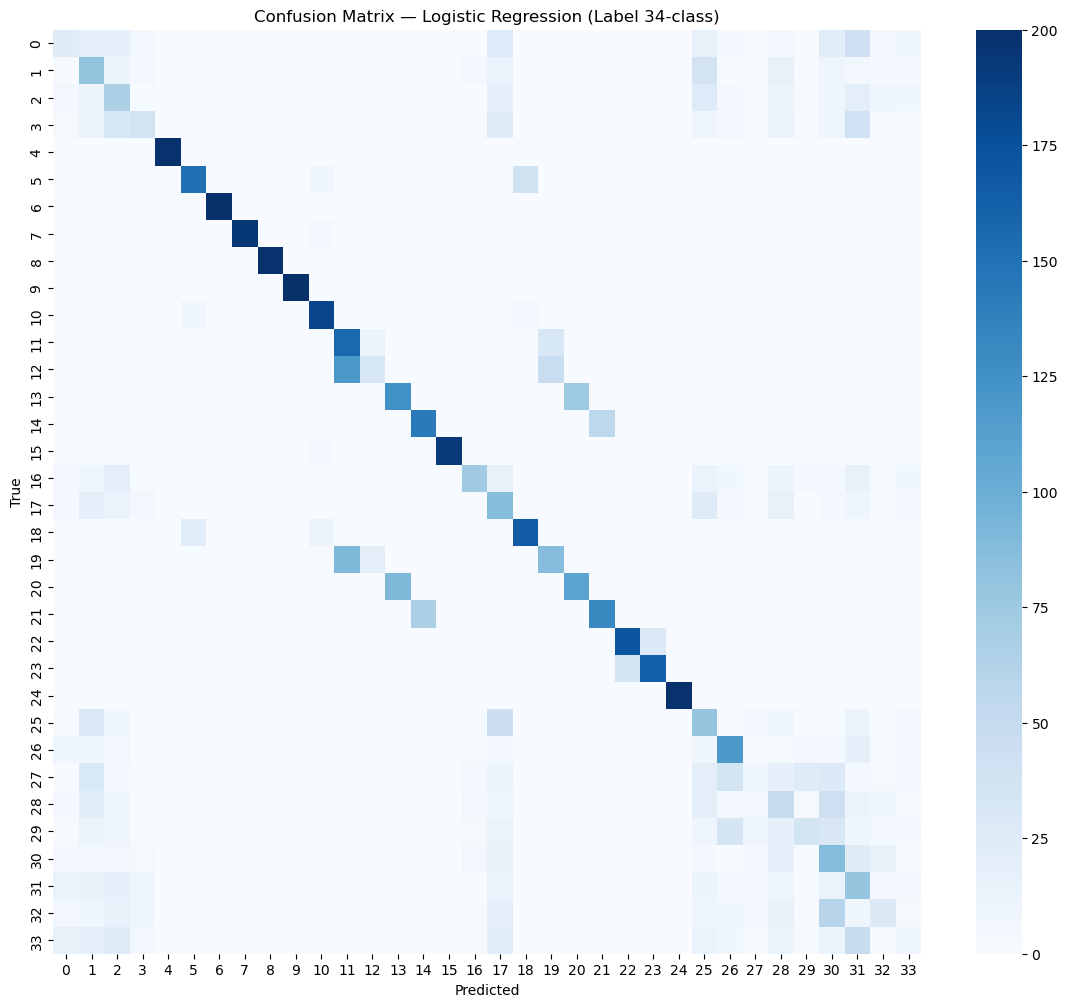

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build the logistic regression pipeline
logreg_label_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=500,
            n_jobs=-1
        ))
    ]
)

# Fit the model
logreg_label_pipeline.fit(X_train_label, y_train_label)
# Predict
label_pred = logreg_label_pipeline.predict(X_test_label)

# Metrics
label_accuracy = accuracy_score(y_test_label, label_pred)
label_precision = precision_score(y_test_label, label_pred, average="macro", zero_division=0)
label_recall = recall_score(y_test_label, label_pred, average="macro", zero_division=0)
label_f1 = f1_score(y_test_label, label_pred, average="macro", zero_division=0)

print("=== Logistic Regression — Label (34-class) ===")
print(f"Accuracy:  {label_accuracy:.4f}")
print(f"Precision (macro): {label_precision:.4f}")
print(f"Recall (macro):    {label_recall:.4f}")
print(f"F1-score (macro):  {label_f1:.4f}")

# Confusion Matrix
cm_label = confusion_matrix(y_test_label, label_pred, labels=logreg_label_pipeline.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_label, annot=False, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Label 34-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 5.3 Logistic Regression for 'Label_Family' (8 Classes)

c:\Users\graha\anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Logistic Regression — Label_Family (7-class) ===
Accuracy:  0.6229
Precision (macro): 0.6371
Recall (macro):    0.6229
F1-score (macro):  0.6222


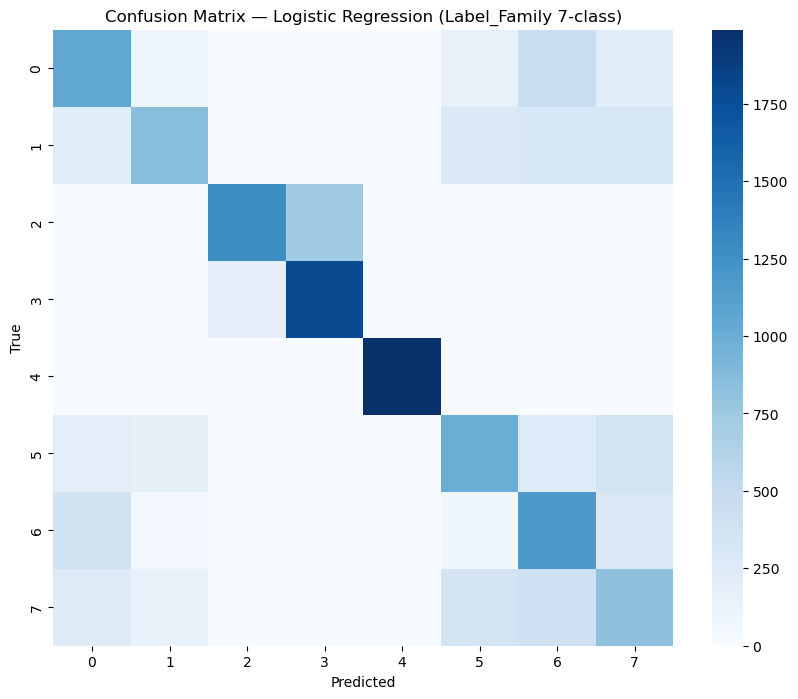

In [19]:
# Build pipeline
logreg_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            max_iter=500,
            n_jobs=-1
        ))
    ]
)

# Fit
logreg_family_pipeline.fit(X_train_family, y_train_family)

# Predict
family_pred = logreg_family_pipeline.predict(X_test_family)

# Metrics
family_accuracy = accuracy_score(y_test_family, family_pred)
family_precision = precision_score(y_test_family, family_pred, average="macro", zero_division=0)
family_recall = recall_score(y_test_family, family_pred, average="macro", zero_division=0)
family_f1 = f1_score(y_test_family, family_pred, average="macro", zero_division=0)

print("=== Logistic Regression — Label_Family (7-class) ===")
print(f"Accuracy:  {family_accuracy:.4f}")
print(f"Precision (macro): {family_precision:.4f}")
print(f"Recall (macro):    {family_recall:.4f}")
print(f"F1-score (macro):  {family_f1:.4f}")

# Confusion Matrix
cm_family = confusion_matrix(y_test_family, family_pred, labels=logreg_family_pipeline.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_family, annot=False, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Label_Family 7-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 5.4 Logistic Regression for 'Label_binary' (2 Classes)

=== Logistic Regression — Label_Binary (2-class) ===
Accuracy:  0.9813
Precision: 0.9994
Recall:    0.9631
F1-score:  0.9809


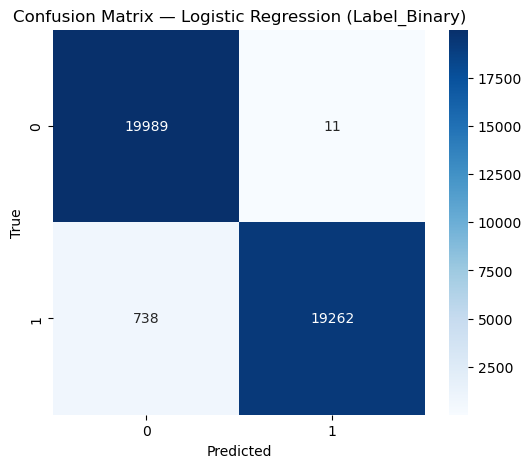

In [20]:
# Binary LR pipeline
logreg_binary_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            solver="lbfgs",
            max_iter=500,
            n_jobs=-1
        ))
    ]
)

# Fit
logreg_binary_pipeline.fit(X_train_binary, y_train_binary)

# Predict
binary_pred = logreg_binary_pipeline.predict(X_test_binary)

# Metrics
binary_accuracy = accuracy_score(y_test_binary, binary_pred)
binary_precision = precision_score(y_test_binary, binary_pred, average="binary", zero_division=0)
binary_recall = recall_score(y_test_binary, binary_pred, average="binary", zero_division=0)
binary_f1 = f1_score(y_test_binary, binary_pred, average="binary", zero_division=0)

print("=== Logistic Regression — Label_Binary (2-class) ===")
print(f"Accuracy:  {binary_accuracy:.4f}")
print(f"Precision: {binary_precision:.4f}")
print(f"Recall:    {binary_recall:.4f}")
print(f"F1-score:  {binary_f1:.4f}")

# Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, binary_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Label_Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6. Linear Support Vector Machine Models

### 6.2 Linear SVM for 'Label' (34 Classes)

=== Linear SVM — Label (34-class) ===
Accuracy:  0.5515
Precision (macro): 0.5582
Recall (macro):    0.5515
F1-score (macro):  0.5326


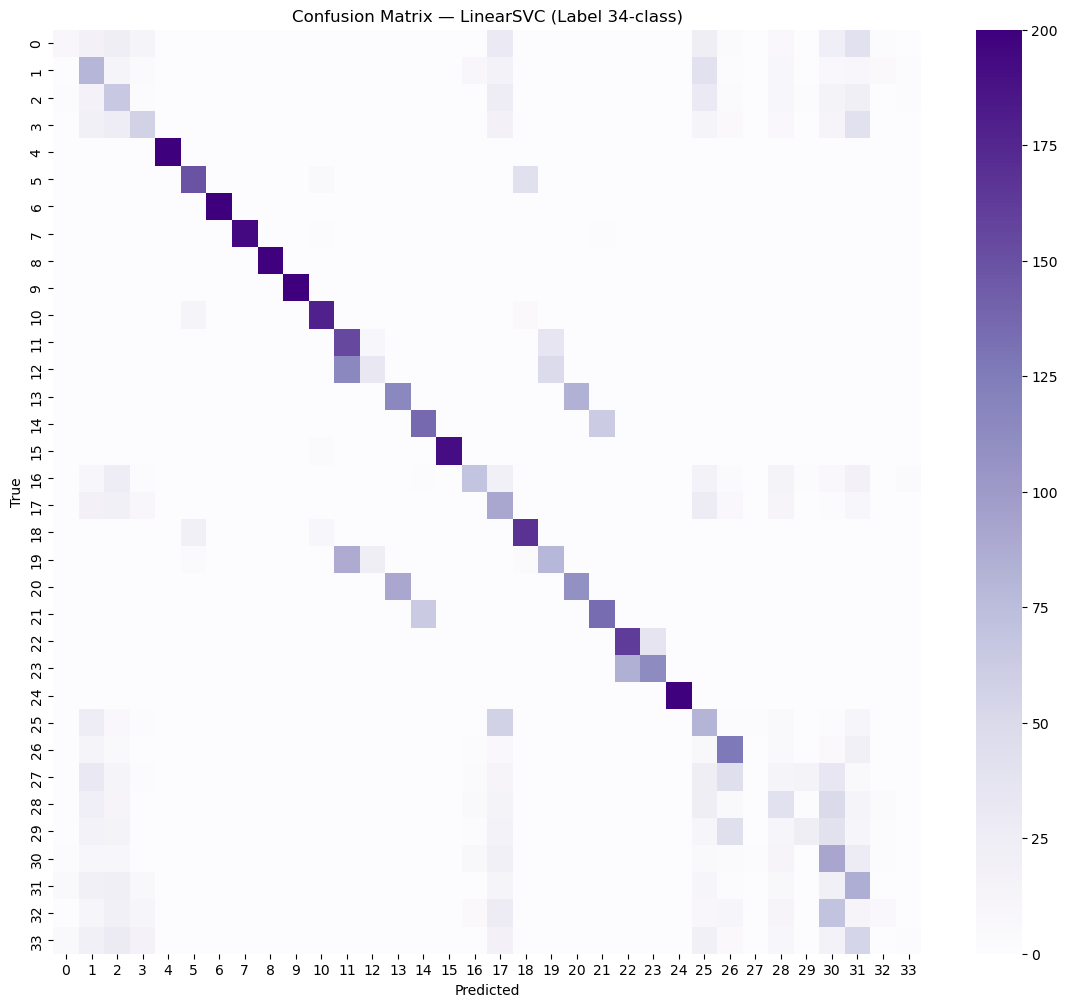

In [21]:

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Linear SVM pipeline
linearsvc_label_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearSVC(
            C=1.0,
            max_iter=5000,
            dual=False   # recommended when #samples > #features (often true after one-hot)
        ))
    ]
)

# Fit
linearsvc_label_pipeline.fit(X_train_label, y_train_label)

# Predict
label_svm_pred = linearsvc_label_pipeline.predict(X_test_label)

# Metrics
label_svm_accuracy = accuracy_score(y_test_label, label_svm_pred)
label_svm_precision = precision_score(y_test_label, label_svm_pred, average="macro", zero_division=0)
label_svm_recall = recall_score(y_test_label, label_svm_pred, average="macro", zero_division=0)
label_svm_f1 = f1_score(y_test_label, label_svm_pred, average="macro", zero_division=0)

print("=== Linear SVM — Label (34-class) ===")
print(f"Accuracy:  {label_svm_accuracy:.4f}")
print(f"Precision (macro): {label_svm_precision:.4f}")
print(f"Recall (macro):    {label_svm_recall:.4f}")
print(f"F1-score (macro):  {label_svm_f1:.4f}")

# Confusion Matrix
cm_label_svm = confusion_matrix(y_test_label, label_svm_pred, labels=linearsvc_label_pipeline.classes_)

plt.figure(figsize=(14, 12))
sns.heatmap(cm_label_svm, annot=False, cmap="Purples")
plt.title("Confusion Matrix — LinearSVC (Label 34-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 6.3 Linear SVM for 'Label_Family' (8 Classes)

=== Linear SVM — Label_Family (7-class) ===
Accuracy:  0.6179
Precision (macro): 0.6457
Recall (macro):    0.6179
F1-score (macro):  0.6170


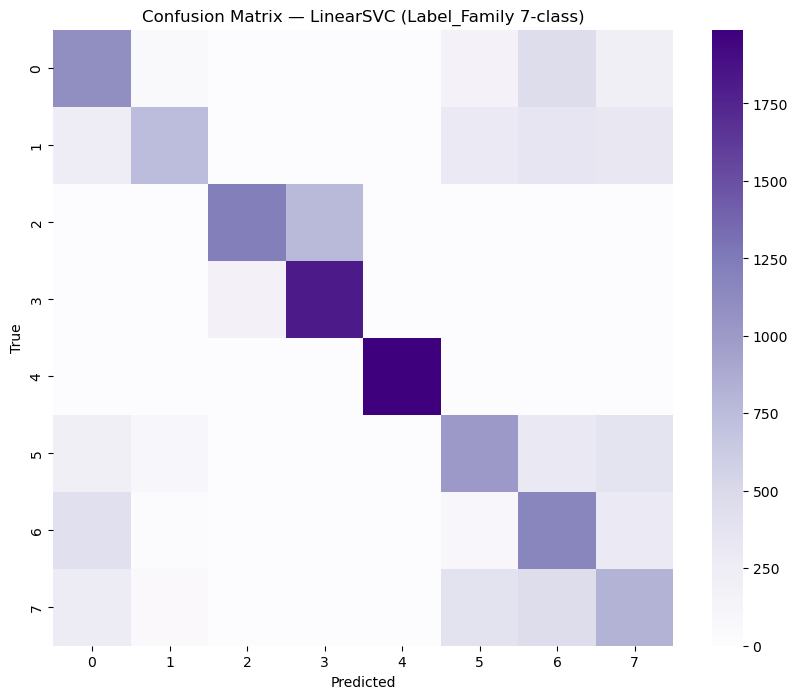

In [22]:
# Linear SVM pipeline for Label_Family
linearsvc_family_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearSVC(
            C=1.0,
            max_iter=5000,
            dual=False    # recommended for high-dimensional, more samples than features
        ))
    ]
)

# Fit
linearsvc_family_pipeline.fit(X_train_family, y_train_family)

# Predict
family_svm_pred = linearsvc_family_pipeline.predict(X_test_family)

# Metrics
family_svm_accuracy = accuracy_score(y_test_family, family_svm_pred)
family_svm_precision = precision_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_recall = recall_score(y_test_family, family_svm_pred, average="macro", zero_division=0)
family_svm_f1 = f1_score(y_test_family, family_svm_pred, average="macro", zero_division=0)

print("=== Linear SVM — Label_Family (7-class) ===")
print(f"Accuracy:  {family_svm_accuracy:.4f}")
print(f"Precision (macro): {family_svm_precision:.4f}")
print(f"Recall (macro):    {family_svm_recall:.4f}")
print(f"F1-score (macro):  {family_svm_f1:.4f}")

# Confusion Matrix
cm_family_svm = confusion_matrix(y_test_family, family_svm_pred, labels=linearsvc_family_pipeline.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_family_svm, annot=False, cmap="Purples")
plt.title("Confusion Matrix — LinearSVC (Label_Family 7-class)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### 6.4 Linear SVM for 'Label_binary' (2 Classes)

=== Linear SVM — Label_Binary (2-class) ===
Accuracy:  0.9812
Precision: 1.0000
Recall:    0.9625
F1-score:  0.9809


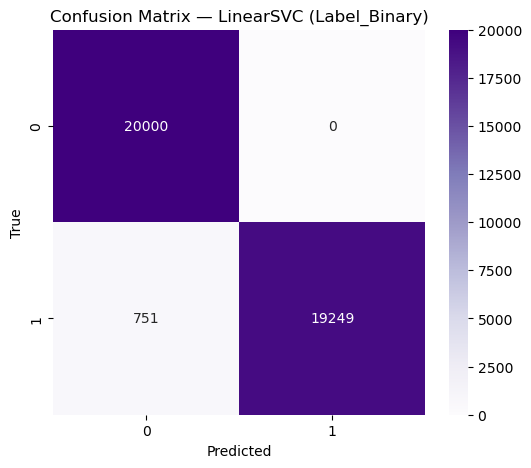

In [23]:
# Linear SVM pipeline for Label_Binary
linearsvc_binary_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearSVC(
            C=1.0,
            max_iter=5000,
            dual=False   # typical for n_samples > n_features
        ))
    ]
)

# Fit
linearsvc_binary_pipeline.fit(X_train_binary, y_train_binary)

# Predict
binary_svm_pred = linearsvc_binary_pipeline.predict(X_test_binary)

# Metrics
binary_svm_accuracy = accuracy_score(y_test_binary, binary_svm_pred)
binary_svm_precision = precision_score(y_test_binary, binary_svm_pred, average="binary", zero_division=0)
binary_svm_recall = recall_score(y_test_binary, binary_svm_pred, average="binary", zero_division=0)
binary_svm_f1 = f1_score(y_test_binary, binary_svm_pred, average="binary", zero_division=0)

print("=== Linear SVM — Label_Binary (2-class) ===")
print(f"Accuracy:  {binary_svm_accuracy:.4f}")
print(f"Precision: {binary_svm_precision:.4f}")
print(f"Recall:    {binary_svm_recall:.4f}")
print(f"F1-score:  {binary_svm_f1:.4f}")

# Confusion Matrix
cm_binary_svm = confusion_matrix(y_test_binary, binary_svm_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_binary_svm, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix — LinearSVC (Label_Binary)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 7. Cross Model and Cross Granularity Comparisons

### 7.1 Summary Table of Metrics

### 7.2 Discussion of Results